<a href="https://colab.research.google.com/github/SunLite9/NBA-3-Pointer-Analysis/blob/main/Nba_3_Pointers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

In [187]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from IPython.display import Markdown, display
import random


In [188]:
def generate_variants(df=None, column=None, min_value=0, max_value=40):
    """Generate dataframes varying one column from min_value to max_value."""
    df_list = list()

    for i in range(len(df)-1):

        df_list.append(pd.DataFrame(df.iloc[i]).transpose())

        df_list[i] = pd.DataFrame(np.repeat(df_list[i].values,
                                  max_value-min_value, axis=0), columns=df_list[i].columns)
        for k in range(min_value,max_value):
            df_list[i][column][k] = k
    return df_list

def predict_best_stats(df, model=None):
    """Predict probabilities and find stats maximizing win probability."""

    results = list()
    max_prob = list()

    for i in range(len(df)-1):

        results.append(model.predict_proba(df[i])[:,1])
        max_prob.append(results[i].argmax())

    return results, max_prob

def display_markdown(text):
    display(Markdown(text))


# Data

In [189]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
# Read the data
df = pd.read_csv('/content/drive/My Drive/nba/games_details.csv')
seasons = pd.read_csv('/content/drive/My Drive/nba/games.csv')[["GAME_ID", "SEASON"]]


In [191]:
df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,42000102,1610612764,WAS,Washington,203078,Bradley Beal,F,NaN,34:36,14.0,...,0.0,4.0,4.0,3.0,1.0,0.0,1.0,0.0,33.0,-22.0
1,42000102,1610612764,WAS,Washington,1629060,Rui Hachimura,F,NaN,25:50,4.0,...,2.0,5.0,7.0,1.0,0.0,0.0,3.0,4.0,11.0,-6.0
2,42000102,1610612764,WAS,Washington,203458,Alex Len,C,NaN,12:11,3.0,...,3.0,2.0,5.0,0.0,1.0,0.0,0.0,2.0,6.0,-11.0
3,42000102,1610612764,WAS,Washington,203526,Raul Neto,G,NaN,19:19,2.0,...,1.0,2.0,3.0,1.0,0.0,0.0,0.0,2.0,4.0,-17.0
4,42000102,1610612764,WAS,Washington,201566,Russell Westbrook,G,NaN,29:07,2.0,...,2.0,4.0,6.0,11.0,0.0,0.0,4.0,0.0,10.0,-16.0


In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615626 entries, 0 to 615625
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            615626 non-null  int64  
 1   TEAM_ID            615626 non-null  int64  
 2   TEAM_ABBREVIATION  615626 non-null  object 
 3   TEAM_CITY          615626 non-null  object 
 4   PLAYER_ID          615626 non-null  int64  
 5   PLAYER_NAME        615626 non-null  object 
 6   START_POSITION     235795 non-null  object 
 7   COMMENT            100048 non-null  object 
 8   MIN                515577 non-null  object 
 9   FGM                515577 non-null  float64
 10  FGA                515577 non-null  float64
 11  FG_PCT             515577 non-null  float64
 12  FG3M               515577 non-null  float64
 13  FG3A               515577 non-null  float64
 14  FG3_PCT            515577 non-null  float64
 15  FTM                515577 non-null  float64
 16  FT

In [193]:
df.drop(["GAME_ID","TEAM_ID","PLAYER_ID"],axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
FGM,515577.0,3.575898,3.017828,0.0,1.00,3.000,5.000,28.0
FGA,515577.0,7.879867,5.653108,0.0,3.00,7.000,11.000,50.0
FG_PCT,515577.0,0.415921,0.251533,0.0,0.25,0.429,0.571,1.0
FG3M,515577.0,0.747698,1.200864,0.0,0.00,0.000,1.000,14.0
FG3A,515577.0,2.098759,2.510032,0.0,0.00,1.000,3.000,24.0
FG3_PCT,515577.0,0.196683,0.289237,0.0,0.00,0.000,0.375,1.0
FTM,515577.0,1.744612,2.359994,0.0,0.00,1.000,3.000,26.0
FTA,515577.0,2.302996,2.897069,0.0,0.00,2.000,4.000,39.0
FT_PCT,515577.0,0.437320,0.427660,0.0,0.00,0.500,0.909,1.0
OREB,515577.0,1.030374,1.403506,0.0,0.00,1.000,2.000,18.0


# Data cleaning

### Duplicated data

In [194]:
df[df.duplicated(subset=["GAME_ID","PLAYER_ID"], keep="first")]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
12942,22000069,1610612763,MEM,Memphis,1628960,Grayson Allen,NaN,DNP - Injury/Illness,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12943,22000069,1610612763,MEM,Memphis,1629007,Jontay Porter,NaN,DNP - Injury/Illness,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12944,22000069,1610612763,MEM,Memphis,1630214,Xavier Tillman,NaN,DNP - Injury/Illness,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12945,22000069,1610612766,CHA,Charlotte,1630176,Vernon Carey Jr.,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12946,22000069,1610612766,CHA,Charlotte,1628370,Malik Monk,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29827,22000002,1610612747,LAL,Los Angeles,2544,LeBron James,F,NaN,28:21,7.0,...,2.0,3.0,5.0,5.0,0.0,0.0,4.0,2.0,22.0,2.0
29828,22000002,1610612747,LAL,Los Angeles,203484,Kentavious Caldwell-Pope,G,NaN,23:03,2.0,...,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,9.0,-9.0
29829,22000002,1610612747,LAL,Los Angeles,203471,Dennis Schroder,G,NaN,27:48,5.0,...,1.0,11.0,12.0,8.0,0.0,0.0,1.0,4.0,14.0,-10.0
29830,22000002,1610612747,LAL,Los Angeles,1628398,Kyle Kuzma,NaN,NaN,26:38,6.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,15.0,1.0


In [195]:
df.drop_duplicates(subset=["GAME_ID","PLAYER_ID"],keep="first",inplace=True)

In [196]:
df = df.groupby(["GAME_ID","TEAM_ID"]).sum()
df = df.reset_index()
df = df.drop(['PLAYER_ID', 'FG_PCT','FG3_PCT','FT_PCT','PLUS_MINUS'],axis=1)

df["FG_PCT"] = df["FGM"]/df["FGA"]*100
df["FG3_PCT"] = df["FG3M"]/df["FG3A"]*100
df["FT_PCT"] = df["FTM"]/df["FTA"]*100

### Null values

In [197]:
print (f"There is still {df.isna().sum().sum()} null values.\n")
print ("There is a game with 3 unique rows.\n")

print(df["GAME_ID"].value_counts().sort_values().tail(5))

display(df[df["GAME_ID"] == 10500109])

#dropping the null row

df = df.drop(index=335,axis=0)
df = df.reset_index().drop("index",axis=1)

There is still 3 null values.

There is a game with 3 unique rows.

GAME_ID
10400084    2
10400085    2
10400087    2
10400089    2
10500109    3
Name: count, dtype: int64


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,...,REB,AST,STL,BLK,TO,PF,PTS,FG_PCT,FG3_PCT,FT_PCT
334,10500109,1610612742,DALDALDALDALDALDALDALDALDAL,DallasDallasDallasDallasDallasDallasDallasDall...,DeSagana DiopDevin HarrisDirk NowitzkiDoug Chr...,0,0,281332281832382625,36.0,73.0,...,37.0,18.0,8.0,9.0,13.0,19.0,103.0,49.315068,31.250000,74.285714
335,10500109,1610612756,PHX,Phoenix,Boris Diaw,0,0,24,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
336,10500109,1610612765,DETDETDETDETDETDETDETDETDETDETDETDETDET,DetroitDetroitDetroitDetroitDetroitDetroitDetr...,Alex AckerAntonio McDyessBen WallaceCarlos Arr...,0,0,113024818292471210251428,40.0,87.0,...,41.0,20.0,7.0,11.0,13.0,29.0,97.0,45.977011,44.444444,86.666667


In [198]:
df.loc[7002, "PTS"] = 90
df.loc[7623,"PTS"] = 103

### Victory label

In [199]:
df = df.sort_values("GAME_ID")
df["VICTORY"] = ""

for i in range(0,len(df)-1,2):
    if df["PTS"][i] > df["PTS"][i+1]:

        df.loc[i , "VICTORY"] = "Yes"
        df.loc[i+1 , "VICTORY"] = "No"

    elif df["PTS"][i] < df["PTS"][i+1]:

        df.loc[i , "VICTORY"] = "No"
        df.loc[i+1 , "VICTORY"] = "Yes"

    else:
        print("Tie game?")
        print(df.iloc[i])

In [200]:
df = pd.merge(df,seasons,how="left",on="GAME_ID")

In [201]:
# Drop specified columns
df = df.drop(columns=["TEAM_ABBREVIATION", "TEAM_CITY", "PLAYER_NAME", "START_POSITION", "COMMENT", "MIN"])


In [202]:
df.head()

,GAME_ID,TEAM_ID,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,STL,BLK,TO,PF,PTS,FG_PCT,FG3_PCT,FT_PCT,VICTORY,SEASON
0,10300001,1610612742,34.0,76.0,2.0,8.0,15.0,30.0,12.0,26.0,...,9.0,4.0,18.0,34.0,85.0,44.736842,25.000000,50.000000,No,2003
1,10300001,1610612762,32.0,70.0,1.0,7.0,25.0,34.0,9.0,32.0,...,8.0,4.0,18.0,26.0,90.0,45.714286,14.285714,73.529412,Yes,2003
2,10300002,1610612749,32.0,75.0,2.0,13.0,28.0,40.0,11.0,32.0,...,9.0,4.0,24.0,26.0,94.0,42.666667,15.384615,70.000000,No,2003
3,10300002,1610612763,40.0,81.0,4.0,15.0,21.0,34.0,14.0,34.0,...,18.0,7.0,25.0,35.0,105.0,49.382716,26.666667,61.764706,Yes,2003
4,10300003,1610612765,34.0,87.0,4.0,9.0,24.0,40.0,12.0,25.0,...,15.0,3.0,13.0,27.0,96.0,39.080460,44.444444,60.000000,No,2003


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49156 entries, 0 to 49155
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GAME_ID  49156 non-null  int64  
 1   TEAM_ID  49156 non-null  int64  
 2   FGM      49156 non-null  float64
 3   FGA      49156 non-null  float64
 4   FG3M     49156 non-null  float64
 5   FG3A     49156 non-null  float64
 6   FTM      49156 non-null  float64
 7   FTA      49156 non-null  float64
 8   OREB     49156 non-null  float64
 9   DREB     49156 non-null  float64
 10  REB      49156 non-null  float64
 11  AST      49156 non-null  float64
 12  STL      49156 non-null  float64
 13  BLK      49156 non-null  float64
 14  TO       49156 non-null  float64
 15  PF       49156 non-null  float64
 16  PTS      49156 non-null  float64
 17  FG_PCT   49156 non-null  float64
 18  FG3_PCT  49156 non-null  float64
 19  FT_PCT   49156 non-null  float64
 20  VICTORY  49156 non-null  object 
 21  SEASON   491

# Exploratory Data Analysis

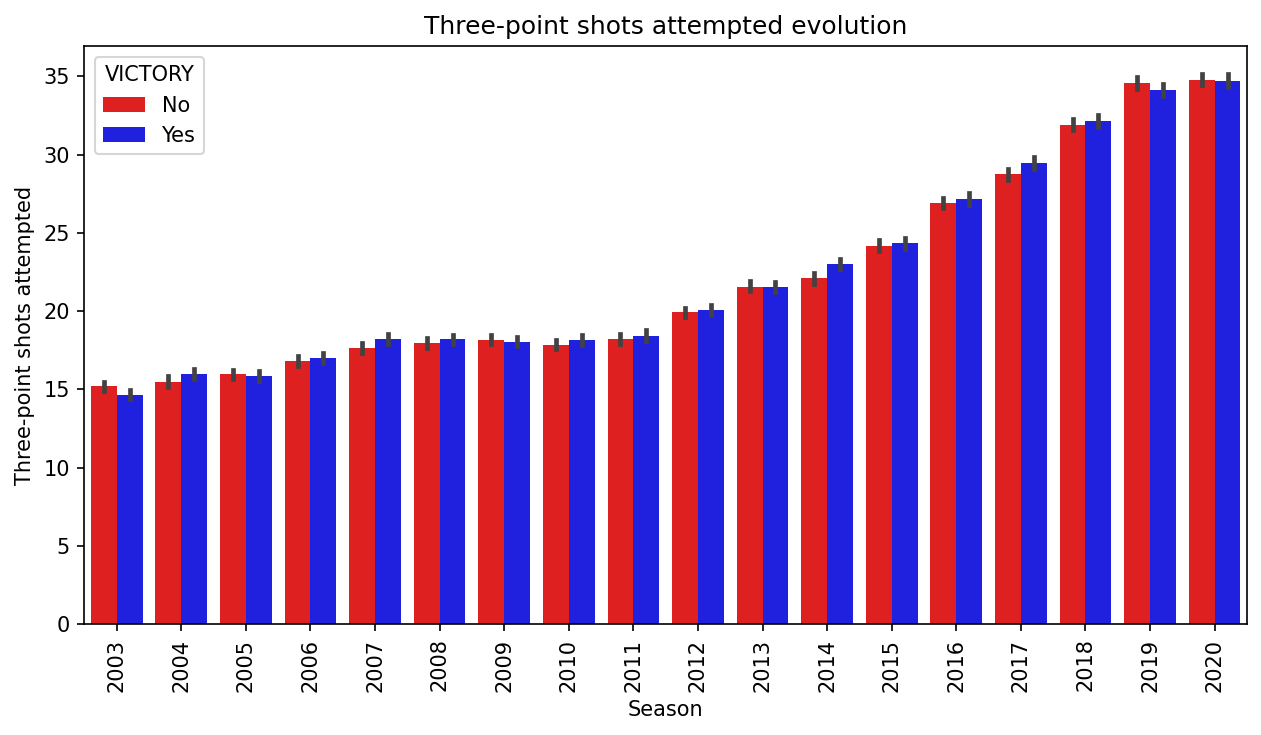

In [204]:
plt.figure(figsize=(10, 5), dpi=150)
ax = sns.barplot(data=df, x="SEASON", y="FG3A", hue="VICTORY", palette=["red", "blue"])

ax.set(ylabel="Three-point shots attempted", xlabel="Season")
ax.set_title("Three-point shots attempted evolution")

plt.xticks(rotation=90)
plt.show()


As the number of three-point attempts has grown, let’s examine how shooting percentages have evolved over the years. The figure below shows that despite the increasing volume of three-point shots, the average three-point percentage has remained steady around 30-35%. This highlights the efficiency of today’s NBA players, who are able to maintain consistent shooting accuracy even with a rising number of long-range attempts each year.

Additionally, the figure reveals an intriguing insight. Unlike the previous chart, shooting percentages appear to be a strong indicator of team success: winning and losing teams show an average percentage difference of at least 5%. This provides a key indication of the offensive side of the game—an efficient offense with high shooting percentages can significantly enhance a team’s performance.


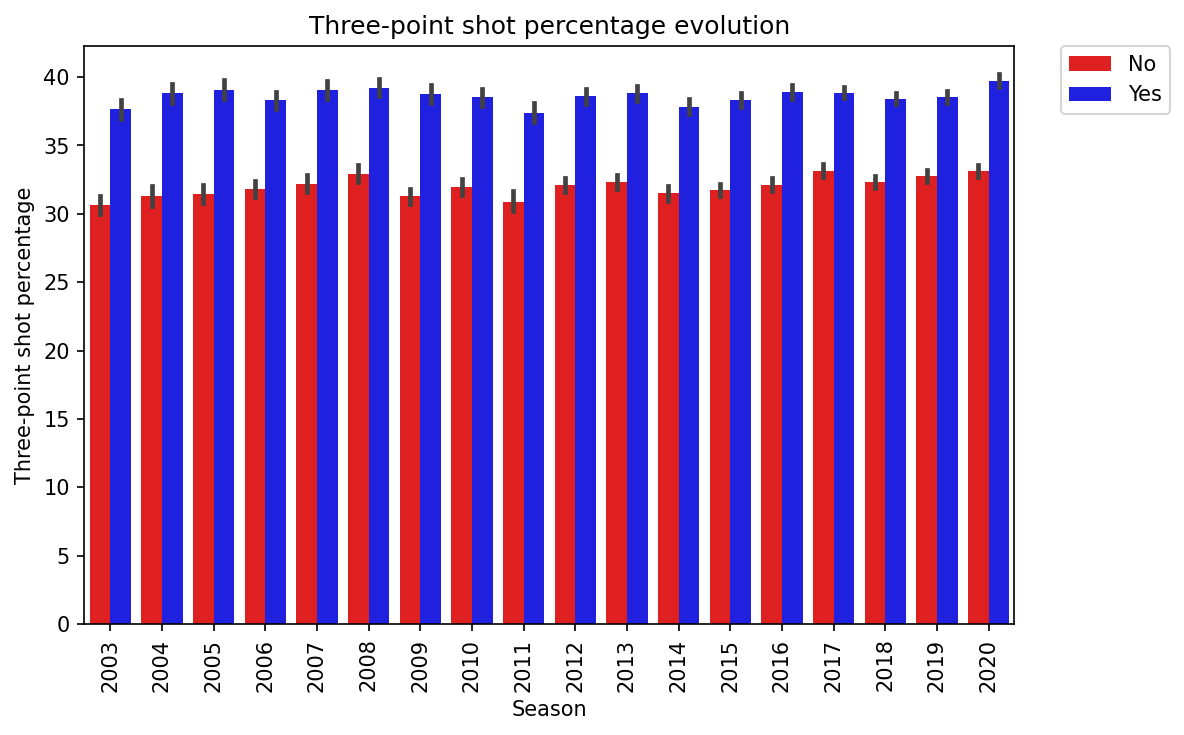

In [205]:
plt.figure(figsize=(8, 5), dpi=150)
ax = sns.barplot(data=df, x="SEASON", y="FG3_PCT", hue="VICTORY", palette=["red", "blue"])

ax.set(ylabel="Three-point shot percentage", xlabel="Season")
ax.set_title("Three-point shot percentage evolution")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.xticks(rotation=90)
plt.show()


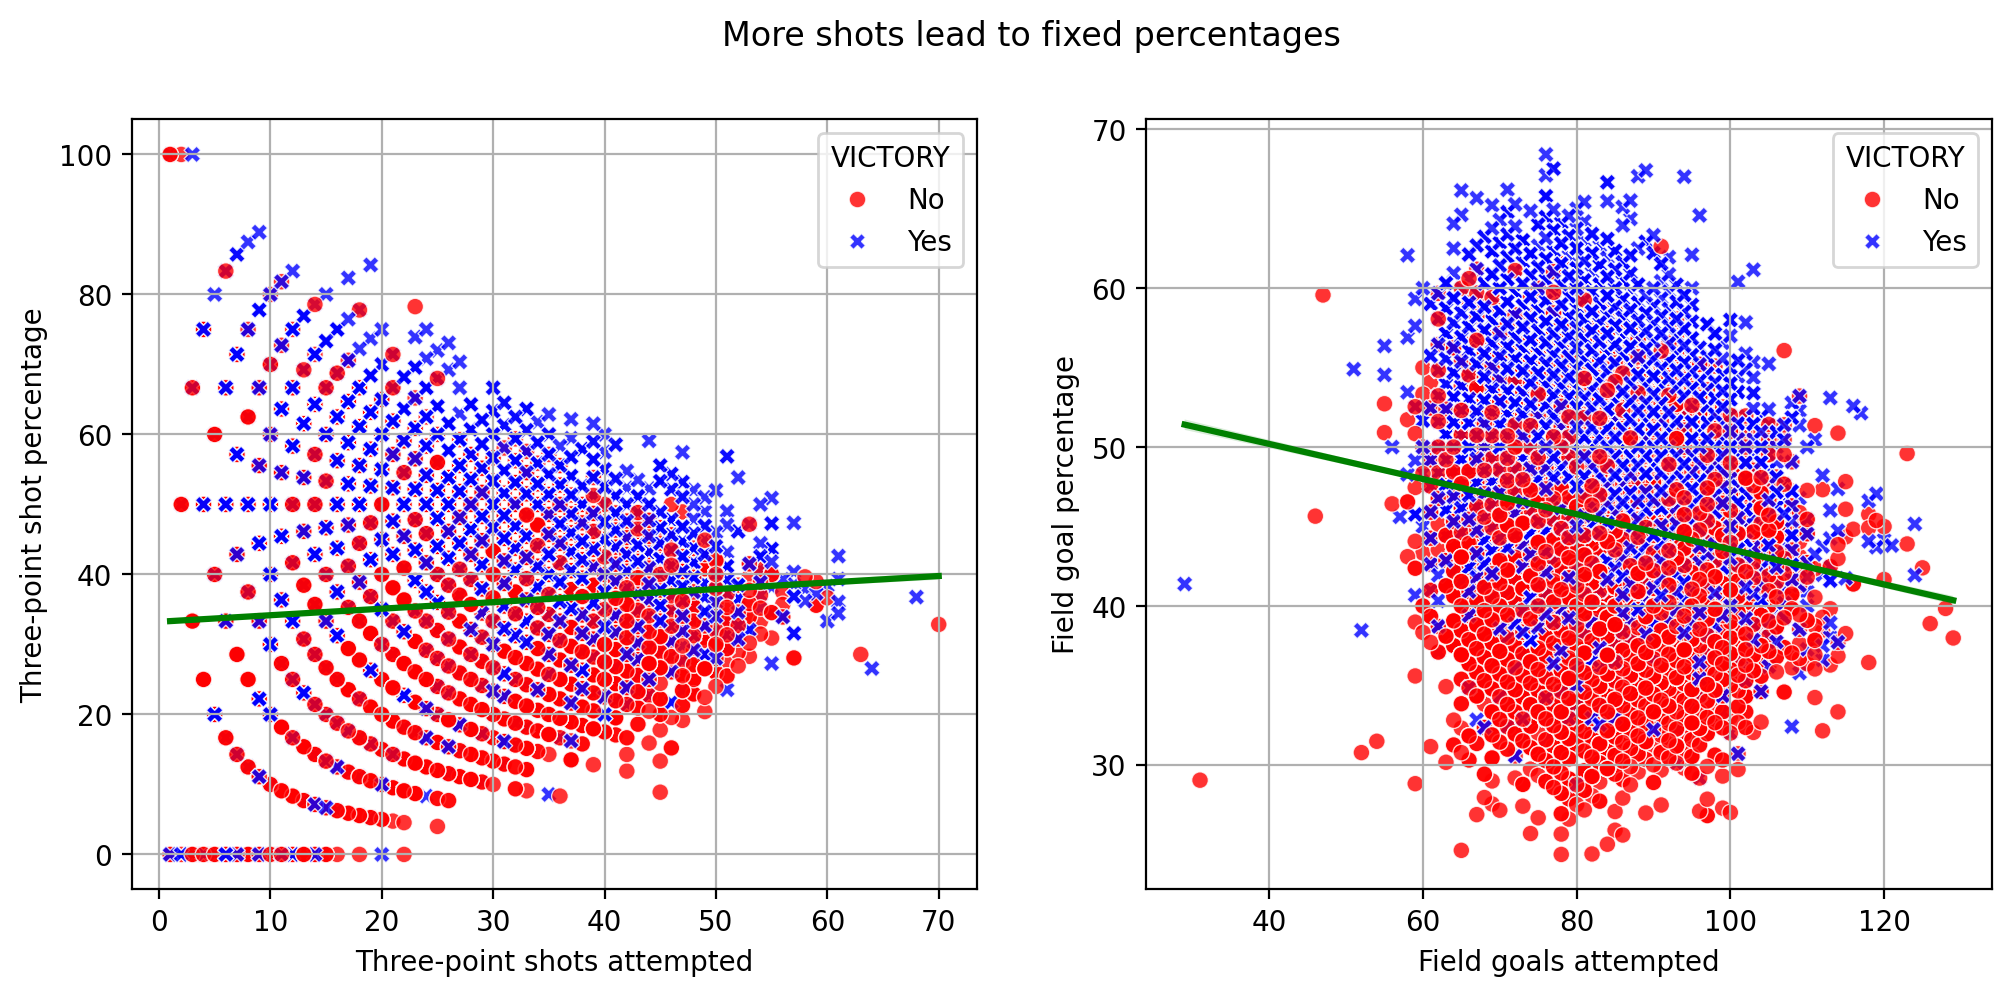

In [206]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

plt.suptitle("More shots lead to fixed percentages")

sns.scatterplot(ax=ax[0], data=df, x="FG3A", y="FG3_PCT", hue="VICTORY", style="VICTORY", alpha=0.8, palette=["red", "blue"])
sns.regplot(ax=ax[0], data=df, x="FG3A", y="FG3_PCT", scatter=False, color="green")
ax[0].grid(True)
ax[0].set(ylabel="Three-point shot percentage", xlabel="Three-point shots attempted")

sns.scatterplot(ax=ax[1], data=df, x="FGA", y="FG_PCT", hue="VICTORY", style="VICTORY", alpha=0.8, palette=["red", "blue"])
sns.regplot(ax=ax[1], data=df, x="FGA", y="FG_PCT", scatter=False, color="green")
ax[1].grid(True)
ax[1].set(ylabel="Field goal percentage", xlabel="Field goals attempted")

plt.show()


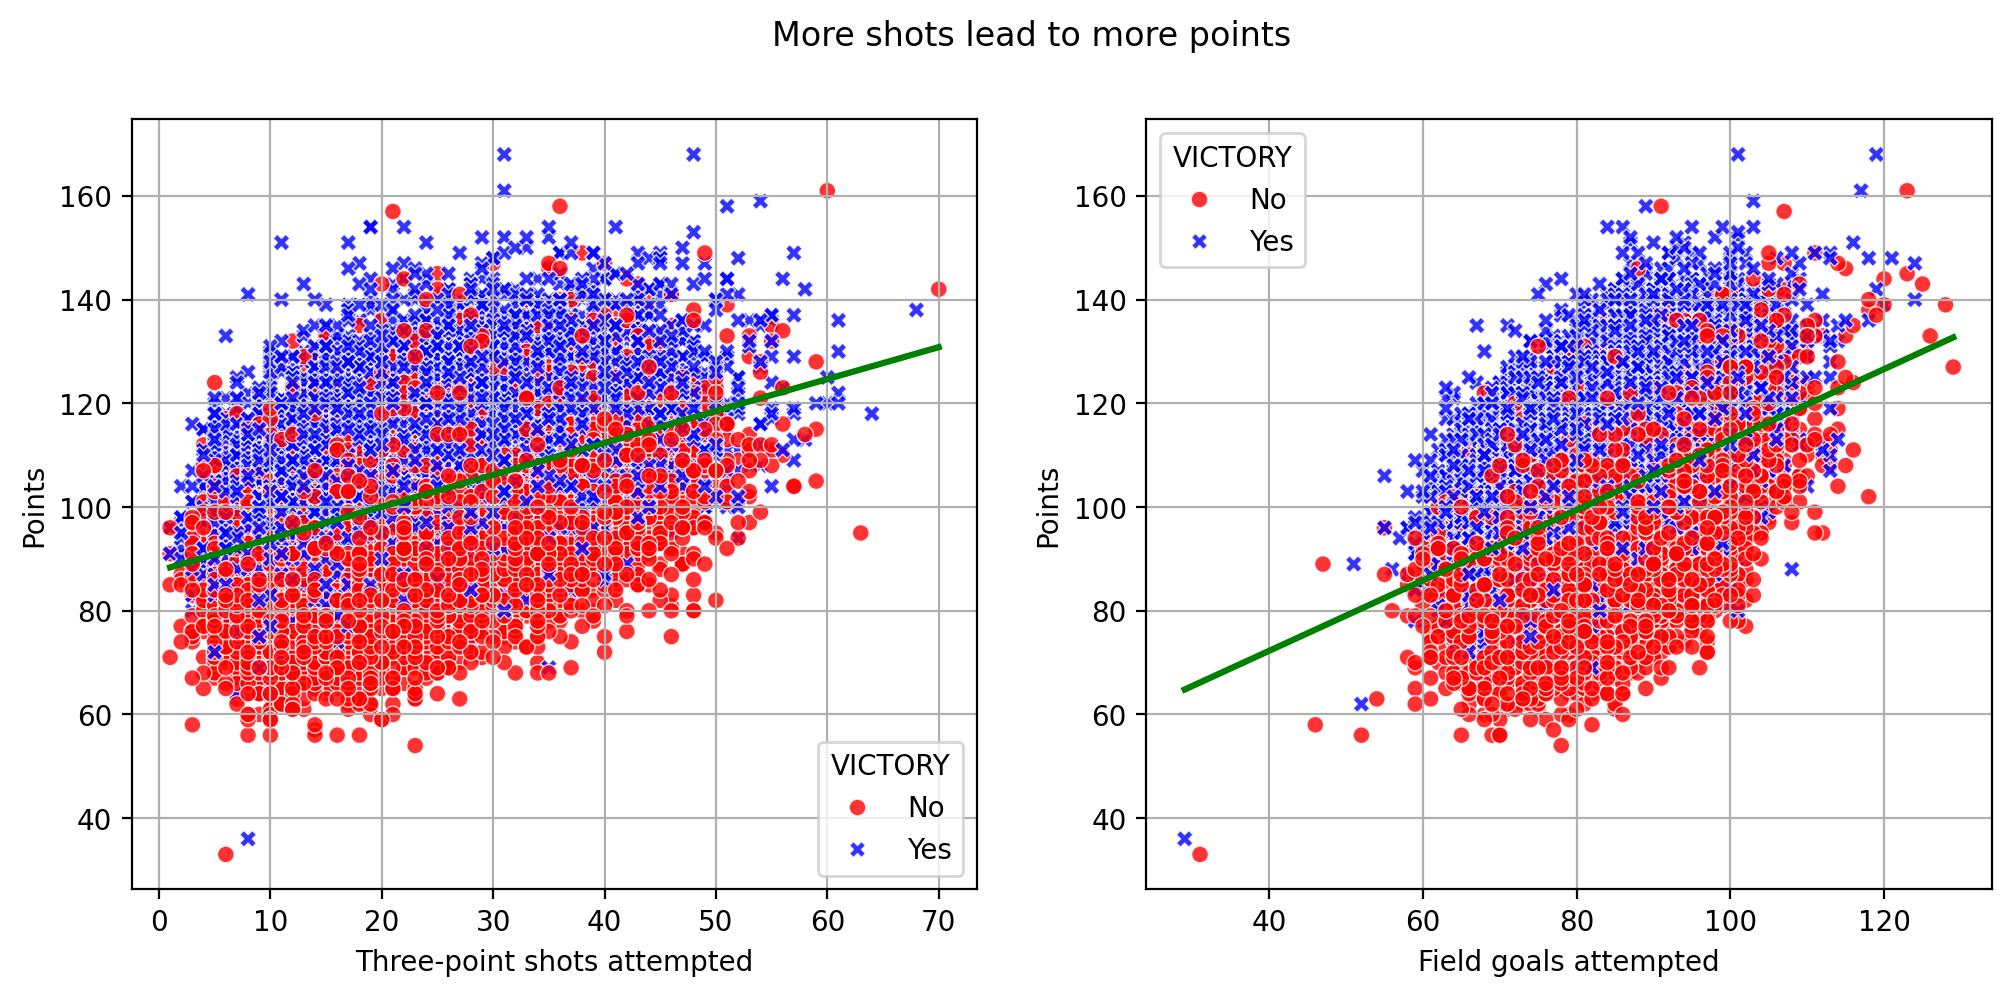

In [207]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

plt.suptitle("More shots lead to more points")

sns.scatterplot(ax=ax[0], data=df, y="PTS", x="FG3A", hue="VICTORY", style="VICTORY", alpha=0.8, palette=["red", "blue"])
sns.regplot(ax=ax[0], data=df, y="PTS", x="FG3A", scatter=False, color="green")
ax[0].grid(True)
ax[0].set(xlabel="Three-point shots attempted", ylabel="Points")

sns.scatterplot(ax=ax[1], data=df, y="PTS", x="FGA", hue="VICTORY", style="VICTORY", alpha=0.8, palette=["red", "blue"])
sns.regplot(ax=ax[1], data=df, y="PTS", x="FGA", scatter=False, color="green")
ax[1].grid(True)
ax[1].set(xlabel="Field goals attempted", ylabel="Points")

plt.show()


# Machine Learning model



Random Forest Classifier selecting the following features:
* Field goals attempted per game
* Three point shots attempted per game
* Free throws attempted per game
* Field goals percentage per game
* Three point shots percentage per game
* Free throws percentage per game
* Offensive rebounds per game
* Defensive rebounds per game
* Assists per game
* Steels per game
* Blocks per game
* Turnovers per game
* Fouls per game

The data was split to account for changes in gameplay and strategy before and after 2014, a shift driven by players like Steph Curry, who popularized the three-point shot. This separation allows the models to capture patterns unique to each period, improving prediction accuracy by adapting to evolving playstyles and increased three-point attempts post-2014.

In [208]:
# Divide the data into two parts
first_split = df[df["SEASON"] < 2014]  # 2003-2013
second_split = df[df["SEASON"] >= 2014]  # 2014-2020

# ML model (2003-2013)

# Split
X1 = first_split.drop(["SEASON","VICTORY","FGM","FTM","FG3M","PTS","GAME_ID","TEAM_ID","REB"], axis=1)
y1 = first_split["VICTORY"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=27)

# Train
model_first_split = RandomForestClassifier(bootstrap=True)
model_first_split.fit(X1_train, y1_train)

# Predict
y1_pred = model_first_split.predict(X1_test)

# ML model for the second chunk of data (2014-2020)

# Split
X2 = second_split.drop(["SEASON","VICTORY","FGM","FTM","FG3M","PTS","GAME_ID","TEAM_ID","REB"], axis=1)
y2 = second_split["VICTORY"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=27)

# Train
model_second_split = RandomForestClassifier(bootstrap=True)
model_second_split.fit(X2_train, y2_train)

# Predict
y2_pred = model_second_split.predict(X2_test)


In [209]:
display_markdown("These are the results for the first model (2003-2013)\n")
print(classification_report(y1_test,y1_pred))

display_markdown("These are the results for the second model (2014-2020)\n")
print(classification_report(y2_test,y2_pred))


These are the results for the first model (2003-2013)


              precision    recall  f1-score   support

          No       0.81      0.82      0.82      4571
         Yes       0.82      0.81      0.81      4509

    accuracy                           0.81      9080
   macro avg       0.81      0.81      0.81      9080
weighted avg       0.81      0.81      0.81      9080



These are the results for the second model (2014-2020)


              precision    recall  f1-score   support

          No       0.81      0.81      0.81      2874
         Yes       0.81      0.81      0.81      2794

    accuracy                           0.81      5668
   macro avg       0.81      0.81      0.81      5668
weighted avg       0.81      0.81      0.81      5668



Both models, trained on data from 2003-2013 and 2014-2020, achieved consistent accuracy scores of 81%, with similar precision, recall, and F1-scores across classes. This suggests that the predictive power of the features remains stable over time, indicating that the factors used in the model are effective in predicting outcomes across different NBA eras.

In [210]:
first_split_list = generate_variants(X1_test,"FG3A",0,60)
results_first_split, max_prob_first_split = predict_best_stats(first_split_list, model_first_split)

second_split_list = generate_variants(X2_test,"FG3A",0,60)
results_second_split, max_prob_second_split = predict_best_stats(second_split_list, model_second_split)


Streaming output truncated to the last 5000 lines.

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-188-2821e443063c>:12: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignme

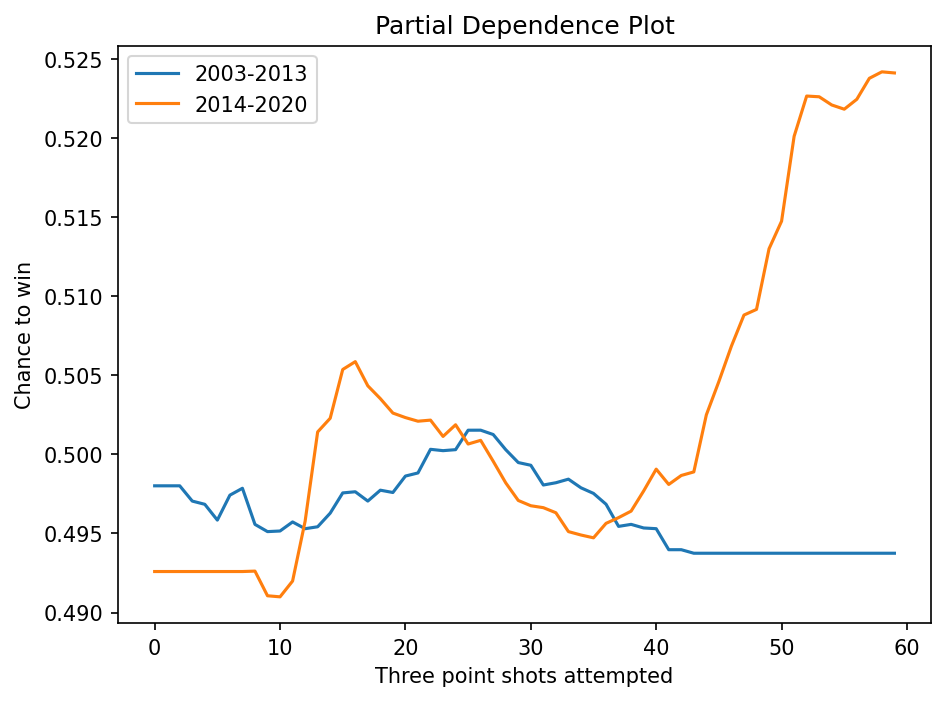

In [211]:
average1 = np.sum(results_first_split,axis=0)/len(results_first_split)
average2 = np.sum(results_second_split,axis=0)/len(results_second_split)

plt.figure(figsize=(7,5),dpi=150)

plt.plot(range(60),average1)
plt.plot(range(60),average2)

plt.legend(["2003-2013","2014-2020"])
plt.xlabel("Three point shots attempted")
plt.ylabel("Chance to win")
plt.title("Partial Dependence Plot")

plt.show()

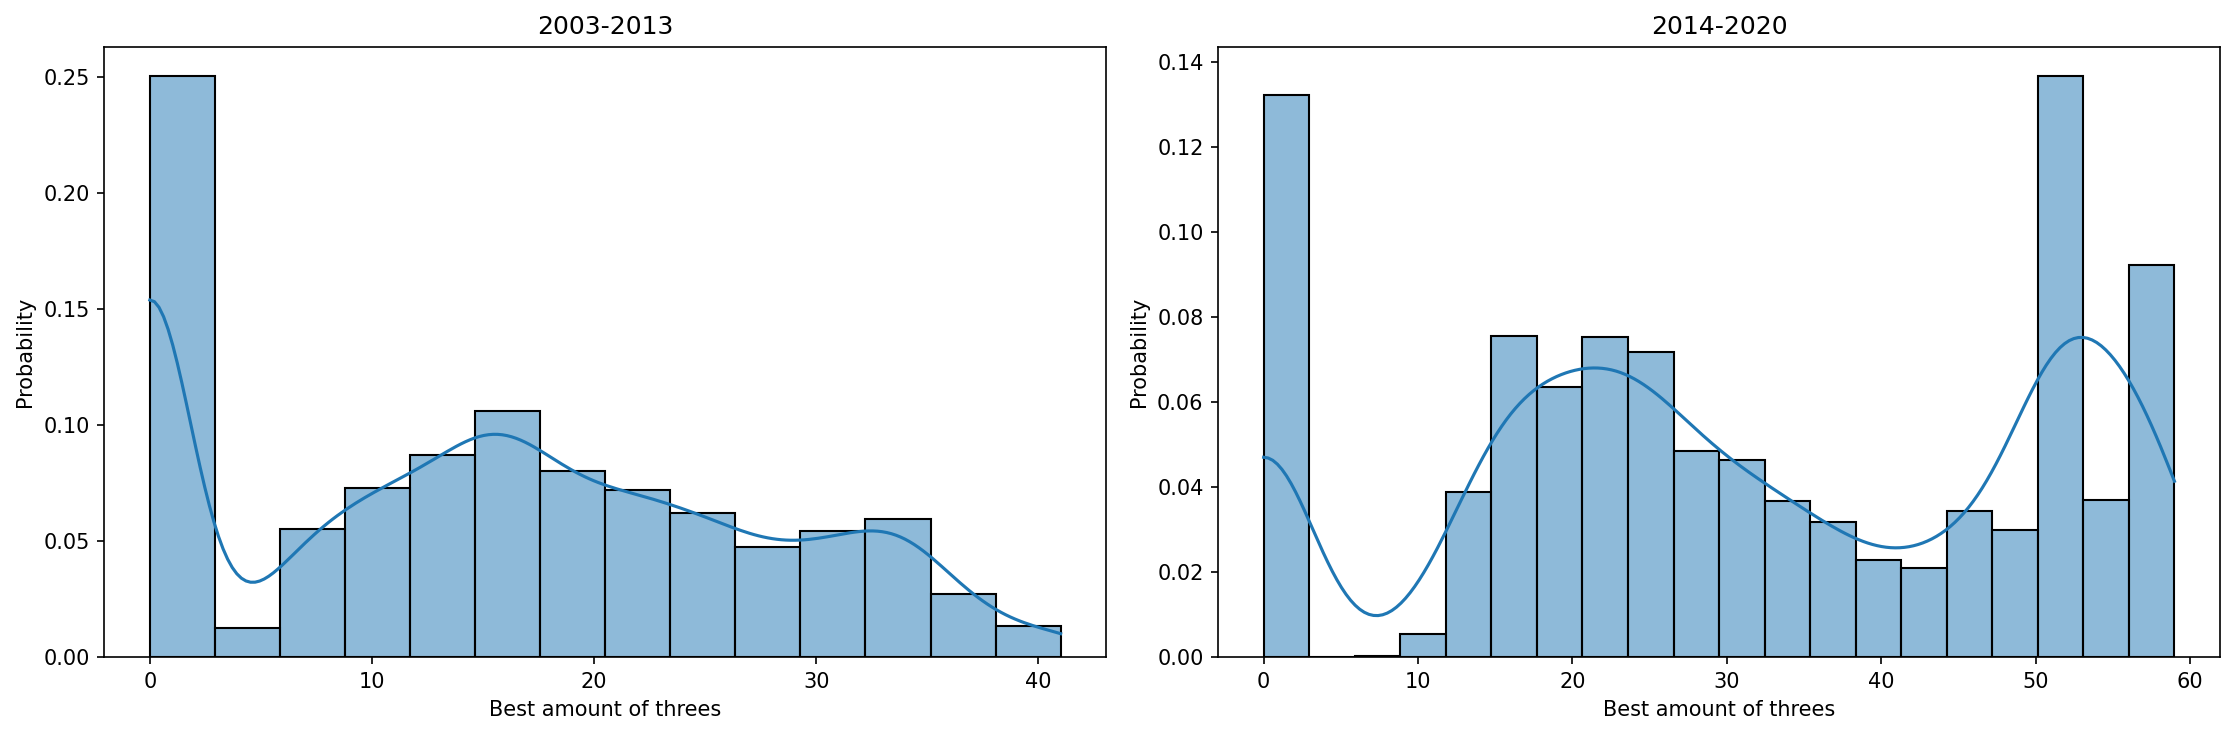

In [212]:
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=150)

sns.histplot(ax = ax[0], x = max_prob_first_split, kde=True, stat="probability", binwidth=3)
ax[0].set(xlabel="Best amount of threes", title="2003-2013")

sns.histplot(ax = ax[1], x = max_prob_second_split, kde=True, stat="probability", binwidth=3)
ax[1].set(xlabel="Best amount of threes", title="2014-2020")


plt.tight_layout()
plt.show()

# Which playstyle is the best?

In [213]:
old_school_pred = model_second_split.predict_proba(X1)
new_school_pred = model_first_split.predict_proba(X2)

lose_mean_old = old_school_pred.mean(axis=0)[0]
win_mean_old = old_school_pred.mean(axis=0)[1]
lose_mean_new = new_school_pred.mean(axis=0)[0]
win_mean_new = new_school_pred.mean(axis=0)[1]

print("Old style team playing in the modern NBA win rate  =", win_mean_old,
     "\nNew style team playin in the past NBA win rate =", win_mean_new)

Old style team playing in the modern NBA win rate  = 0.41393999471319304 
New style team playin in the past NBA win rate = 0.5851434469616715


The results indicate that an old-school team style has a lower predicted win rate when playing in the modern NBA environment (41.39%), while a new-school team style achieves a higher win rate when hypothetically playing in the past NBA (58.35%). This suggests that modern playstyles are more adaptable and effective across different NBA eras, potentially due to their emphasis on three-point shooting and faster gameplay.